In [46]:
import os, sys

from keras.models import Model
from keras.layers import Input, LSTM, GRU, Dense, Embedding, \
  Bidirectional, RepeatVector, Concatenate, Activation, Dot, Lambda
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt

if len(K.tensorflow_backend._get_available_gpus()) > 0:
  from keras.layers import CuDNNLSTM as LSTM
  from keras.layers import CuDNNGRU as GRU

import jieba

In [23]:
# make sure we do softmax over the time axis
# expected shape is N x T x D
# note: the latest version of Keras allows you to pass in axis arg
def softmax_over_time(x):
  assert(K.ndim(x) > 2)
  e = K.exp(x - K.max(x, axis=1, keepdims=True))
  s = K.sum(e, axis=1, keepdims=True)
  return e / s

In [24]:
# config
BATCH_SIZE = 64
EPOCHS = 100
LATENT_DIM = 256
LATENT_DIM_DECODER = 256 # idea: make it different to ensure things all fit together properly!
NUM_SAMPLES = 10000
MAX_SEQUENCE_LENGTH = 100
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100

In [25]:
input_texts = []
target_texts = [] 
target_texts_inputs = [] 

t = 0
for line in open('../../machine_learning_examples/large_files/translation/cmn.txt', encoding='utf-8'):
  t += 1
  if t > NUM_SAMPLES:
    break

  if '\t' not in line:
    continue

  input_text, translation, _ = line.rstrip().split('\t')

  target_text = translation 
  target_text_input = translation

  input_texts.append(input_text)
  target_texts.append(target_text)
  target_texts_inputs.append(target_text_input)
print("num samples:", len(input_texts))

num samples: 10000


In [26]:
# tokenize the inputs
tokenizer_inputs = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences = tokenizer_inputs.texts_to_sequences(input_texts)

# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

Found 3472 unique input tokens.


In [27]:
max_len_input = max(len(s) for s in input_sequences)

In [28]:
#for chinese, using jieba to tokenize => establish word2idx => establish target sequences

stop_words = []
with open('../../machine_learning_examples/corpus/stop_words.txt') as f:
    for line in f:
        stop_words.append(line.rstrip())

In [29]:
target_seg = []
target_input_seg = []
for t in target_texts:
    seg = jieba.lcut(t)
    seg = [s for s in seg if s not in stop_words]
    target_seg.append(seg + ['<eos>'])
    target_input_seg.append(['<sos>'] + seg)

In [30]:
word2idx_outputs = {}

for L in target_seg:
    for token in L + ['<sos>']:
        if token not in word2idx_outputs:
            word2idx_outputs[token] = len(word2idx_outputs) + 1

In [31]:
target_sequences = []
target_input_sequences = []

for L in target_seg:
    sequence = []
    for seg in L:
        sequence.append(word2idx_outputs.get(seg))
    target_sequences.append(sequence)

for L in target_input_seg:
    sequence = []
    for seg in L:
        sequence.append(word2idx_outputs.get(seg))
    target_input_sequences.append(sequence)

In [32]:
print('Found %s unique output tokens.' % len(word2idx_outputs))

num_words_output = len(word2idx_outputs) + 1
max_len_target = max(len(s) for s in target_sequences)

Found 6651 unique output tokens.


In [33]:
# pad the sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=max_len_input)
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])

decoder_inputs = pad_sequences(target_input_sequences, maxlen=max_len_target, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)

decoder_targets = pad_sequences(target_sequences, maxlen=max_len_target, padding='post')

encoder_inputs.shape: (10000, 9)
encoder_inputs[0]: [  0   0   0   0   0   0   0   0 911]
decoder_inputs[0]: [3 1 0 0 0 0 0 0 0 0 0 0 0]
decoder_inputs.shape: (10000, 13)


In [34]:
# store all the pre-trained word vectors
word2vec = {}
with open(os.path.join('../../machine_learning_examples/large_files/glove.6B/glove.6B.%sd.txt' % EMBEDDING_DIM), encoding='utf-8') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
    
print('Found %s word vectors.' % len(word2vec))

Found 400000 word vectors.


In [35]:
# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word2idx_inputs) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx_inputs.items():
  if i < MAX_NUM_WORDS:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector

In [36]:
# create embedding layer
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=max_len_input
)

In [37]:
# create targets, since we cannot use sparse
# categorical cross entropy when we have sequences
decoder_targets_one_hot = np.zeros(
  (
    len(input_texts),
    max_len_target,
    num_words_output
  ),
  dtype='float32'
)

# assign the values
for i, d in enumerate(decoder_targets):
  for t, word in enumerate(d):
    decoder_targets_one_hot[i, t, word] = 1

In [38]:
##### build the model #####

# Set up the encoder
encoder_inputs_placeholder = Input(shape=(max_len_input,))
x = embedding_layer(encoder_inputs_placeholder)
encoder = Bidirectional(LSTM(
  LATENT_DIM,
  return_sequences=True,
  # dropout=0.5 
))
encoder_outputs = encoder(x)


# Set up the decoder 
decoder_inputs_placeholder = Input(shape=(max_len_target,))

# this word embedding will not use pre-trained vectors
# although you could
decoder_embedding = Embedding(num_words_output, EMBEDDING_DIM)
decoder_inputs_x = decoder_embedding(decoder_inputs_placeholder)

In [39]:
######### Attention #########
# Attention layers need to be global because they will be repeated Ty times at the decoder
attn_repeat_layer = RepeatVector(max_len_input)
attn_concat_layer = Concatenate(axis=-1)
attn_dense1 = Dense(10, activation='tanh')
attn_dense2 = Dense(1, activation=softmax_over_time)
attn_dot = Dot(axes=1) # to perform the weighted sum of alpha[t] * h[t]

In [40]:
def one_step_attention(h, st_1):
  # h = h(1), ..., h(Tx), shape = (Tx, LATENT_DIM * 2)
  # st_1 = s(t-1), shape = (LATENT_DIM_DECODER,)
 
  # copy s(t-1) Tx times
  # now shape = (Tx, LATENT_DIM_DECODER)
  st_1 = attn_repeat_layer(st_1)

  # Concatenate all h(t)'s with s(t-1)
  # Now of shape (Tx, LATENT_DIM_DECODER + LATENT_DIM * 2)
  x = attn_concat_layer([h, st_1])

  # Neural net first layer
  x = attn_dense1(x)

  # Neural net second layer with special softmax over time
  alphas = attn_dense2(x)

  # "Dot" the alphas and the h's
  # Remember a.dot(b) = sum over a[t] * b[t]
  context = attn_dot([alphas, h])

  return context

In [41]:
# define the rest of the decoder (after attention)
decoder_lstm = LSTM(LATENT_DIM_DECODER, return_state=True)
decoder_dense = Dense(num_words_output, activation='softmax')

initial_s = Input(shape=(LATENT_DIM_DECODER,), name='s0')
initial_c = Input(shape=(LATENT_DIM_DECODER,), name='c0')
context_last_word_concat_layer = Concatenate(axis=2)

In [42]:
# Instead we need to do Ty steps # And in each of those steps, we need to consider all Tx h's  
# s, c will be re-assigned in each iteration of the loop
s = initial_s
c = initial_c

# collect outputs in a list at first
outputs = []
for t in range(max_len_target): # Ty times
  # get the context using attention
  context = one_step_attention(encoder_outputs, s)

  # we need a different layer for each time step
  selector = Lambda(lambda x: x[:, t:t+1])
  xt = selector(decoder_inputs_x)
  
  # combine 
  decoder_lstm_input = context_last_word_concat_layer([context, xt])

  # pass the combined [context, last word] into the LSTM
  # along with [s, c]
  # get the new [s, c] and output
  o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[s, c])

  # final dense layer to get next word prediction
  decoder_outputs = decoder_dense(o)
  outputs.append(decoder_outputs)

In [43]:
# 'outputs' is now a list of length Ty
# each element is of shape (batch size, output vocab size)
# therefore if we simply stack all the outputs into 1 tensor
# it would be of shape T x N x D
# we would like it to be of shape N x T x D

def stack_and_transpose(x):
  # x is a list of length T, each element is a batch_size x output_vocab_size tensor
  x = K.stack(x) # is now T x batch_size x output_vocab_size tensor
  x = K.permute_dimensions(x, pattern=(1, 0, 2)) # is now batch_size x T x output_vocab_size
  return x

# make it a layer
stacker = Lambda(stack_and_transpose)
outputs = stacker(outputs)

# create the model
model = Model(
  inputs=[
    encoder_inputs_placeholder,
    decoder_inputs_placeholder,
    initial_s, 
    initial_c,
  ],
  outputs=outputs
)

In [44]:
def custom_loss(y_true, y_pred):
  # both are of shape N x T x K
  mask = K.cast(y_true > 0, dtype='float32')
  out = mask * y_true * K.log(y_pred)
  return -K.sum(out) / K.sum(mask)


def acc(y_true, y_pred):
  # both are of shape N x T x K
  targ = K.argmax(y_true, axis=-1)
  pred = K.argmax(y_pred, axis=-1)
  correct = K.cast(K.equal(targ, pred), dtype='float32')

  # 0 is padding, don't include those
  mask = K.cast(K.greater(targ, 0), dtype='float32')
  n_correct = K.sum(mask * correct)
  n_total = K.sum(mask)
  return n_correct / n_total

In [47]:
# compile the model
model.compile(optimizer='adam', loss=custom_loss, metrics=[acc])

# train the model
z = np.zeros((len(encoder_inputs), LATENT_DIM_DECODER)) # initial [s, c]

callback = EarlyStopping(monitor='val_loss', patience=5)

r = model.fit(
  [encoder_inputs, decoder_inputs, z, z], decoder_targets_one_hot,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=0.2,
  callbacks=[callback]
)


Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 15s 2ms/step - loss: 3.1529 - acc: 0.0142 - val_loss: 3.2081 - val_acc: 0.0719
Epoch 2/100
8000/8000 [==============================] - 10s 1ms/step - loss: 2.3250 - acc: 0.2060 - val_loss: 3.0837 - val_acc: 0.1969
Epoch 3/100
8000/8000 [==============================] - 10s 1ms/step - loss: 2.2150 - acc: 0.2427 - val_loss: 3.0475 - val_acc: 0.1962
Epoch 4/100
8000/8000 [==============================] - 10s 1ms/step - loss: 2.1531 - acc: 0.2446 - val_loss: 3.0481 - val_acc: 0.1980
Epoch 5/100
8000/8000 [==============================] - 10s 1ms/step - loss: 2.1102 - acc: 0.2475 - val_loss: 3.0301 - val_acc: 0.2021
Epoch 6/100
8000/8000 [==============================] - 10s 1ms/step - loss: 2.0754 - acc: 0.2527 - val_loss: 3.0015 - val_acc: 0.2053
Epoch 7/100
8000/8000 [==============================] - 10s 1ms/step - loss: 2.0302 - acc: 0.2622 - val_loss: 2.9714 - val_acc: 0.2101

In [48]:
model.save('attention.h5')

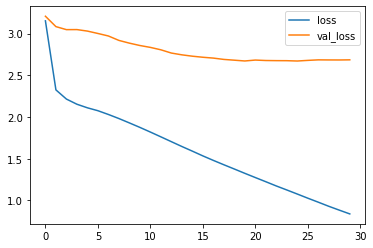

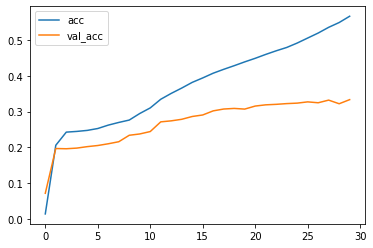

In [49]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

In [50]:
##### Make predictions #####
# As with the poetry example, we need to create another model
# that can take in the RNN state and previous word as input
# and accept a T=1 sequence.

# The encoder will be stand-alone
# From this we will get our initial decoder hidden state
# i.e. h(1), ..., h(Tx)
encoder_model = Model(encoder_inputs_placeholder, encoder_outputs)

# next we define a T=1 decoder model
encoder_outputs_as_input = Input(shape=(max_len_input, LATENT_DIM * 2,))
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding(decoder_inputs_single)

# no need to loop over attention steps this time because there is only one step
context = one_step_attention(encoder_outputs_as_input, initial_s)

# combine context with last word
decoder_lstm_input = context_last_word_concat_layer([context, decoder_inputs_single_x])




# lstm and final dense
o, s, c = decoder_lstm(decoder_lstm_input, initial_state=[initial_s, initial_c])
decoder_outputs = decoder_dense(o)

In [51]:
# note: we don't really need the final stack and tranpose
# because there's only 1 output
# it is already of size N x D
# no need to make it 1 x N x D --> N x 1 x D

In [52]:
# create the model object
decoder_model = Model(
  inputs=[
    decoder_inputs_single,
    encoder_outputs_as_input,
    initial_s, 
    initial_c
  ],
  outputs=[decoder_outputs, s, c]
)



# map indexes back into real words
# so we can view the results
idx2word_eng = {v:k for k, v in word2idx_inputs.items()}
idx2word_trans = {v:k for k, v in word2idx_outputs.items()}

In [53]:
def decode_sequence(input_seq):
  # Encode the input as state vectors.
  enc_out = encoder_model.predict(input_seq)

  # Generate empty target sequence of length 1.
  target_seq = np.zeros((1, 1))
  
  # Populate the first character of target sequence with the start character.
  # NOTE: tokenizer lower-cases all words
  target_seq[0, 0] = word2idx_outputs['<sos>']

  # if we get this we break
  eos = word2idx_outputs['<eos>']


  # [s, c] will be updated in each loop iteration
  s = np.zeros((1, LATENT_DIM_DECODER))
  c = np.zeros((1, LATENT_DIM_DECODER))


  # Create the translation
  output_sentence = []
  for _ in range(max_len_target):
    o, s, c = decoder_model.predict([target_seq, enc_out, s, c])
        

    # Get next word
    idx = np.argmax(o.flatten())

    # End sentence of EOS
    if eos == idx:
      break

    word = ''
    if idx > 0:
      word = idx2word_trans[idx]
      output_sentence.append(word)

    # Update the decoder input
    # which is just the word just generated
    target_seq[0, 0] = idx

  return ' '.join(output_sentence)

In [54]:
while True:
  # Do some test translations
  i = np.random.choice(len(input_texts))
  input_seq = encoder_inputs[i:i+1]
  translation = decode_sequence(input_seq)
  print('-')
  print('Input sentence:', input_texts[i])
  print('Predicted translation:', translation)
  print('Actual translation:', target_texts[i])

  ans = input("Continue? [Y/n]")
  if ans and ans.lower().startswith('n'):
    break

-
Input sentence: The war has not ended.
Predicted translation: 它 是 谁
Actual translation: 战争还没结束。
Continue? [Y/n]y
-
Input sentence: Don't bite on the right side.
Predicted translation: 讓 你 在 哪里
Actual translation: 不要從右邊咬。
Continue? [Y/n]y
-
Input sentence: What time will you leave?
Predicted translation: 你 能 時候 走 了
Actual translation: 你什麼時候離開？
Continue? [Y/n]y
-
Input sentence: Let's just eat.
Predicted translation: 我們 吃 飯
Actual translation: 我們吃吧。
Continue? [Y/n]y
-
Input sentence: The moon was full last night.
Predicted translation: 這 隻 狗 在 床上
Actual translation: 昨晚月亮满了。
Continue? [Y/n]y
-
Input sentence: I've lost my watch.
Predicted translation: 我 的 行李 丢 了 我
Actual translation: 我把我的表丢了。
Continue? [Y/n]n


KeyboardInterrupt: 

In [59]:
53 * 16

848